In [1]:
using DifferentialEquations, Plots, Rsvg, DiffEqProblemLibrary
gr()

Plots.GRBackend()

# Model and example solutions
Here we implement a 1D continuous time random walk approximation of diffusion for $N$ lattice sites, with reflecting boundary conditions

In [2]:
N = 256
jprob = prob_jump_diffnetwork
rn = jprob.network(N)
rnpar = jprob.rates
u0 = jprob.u0(N)
tf = jprob.tstop

10.0

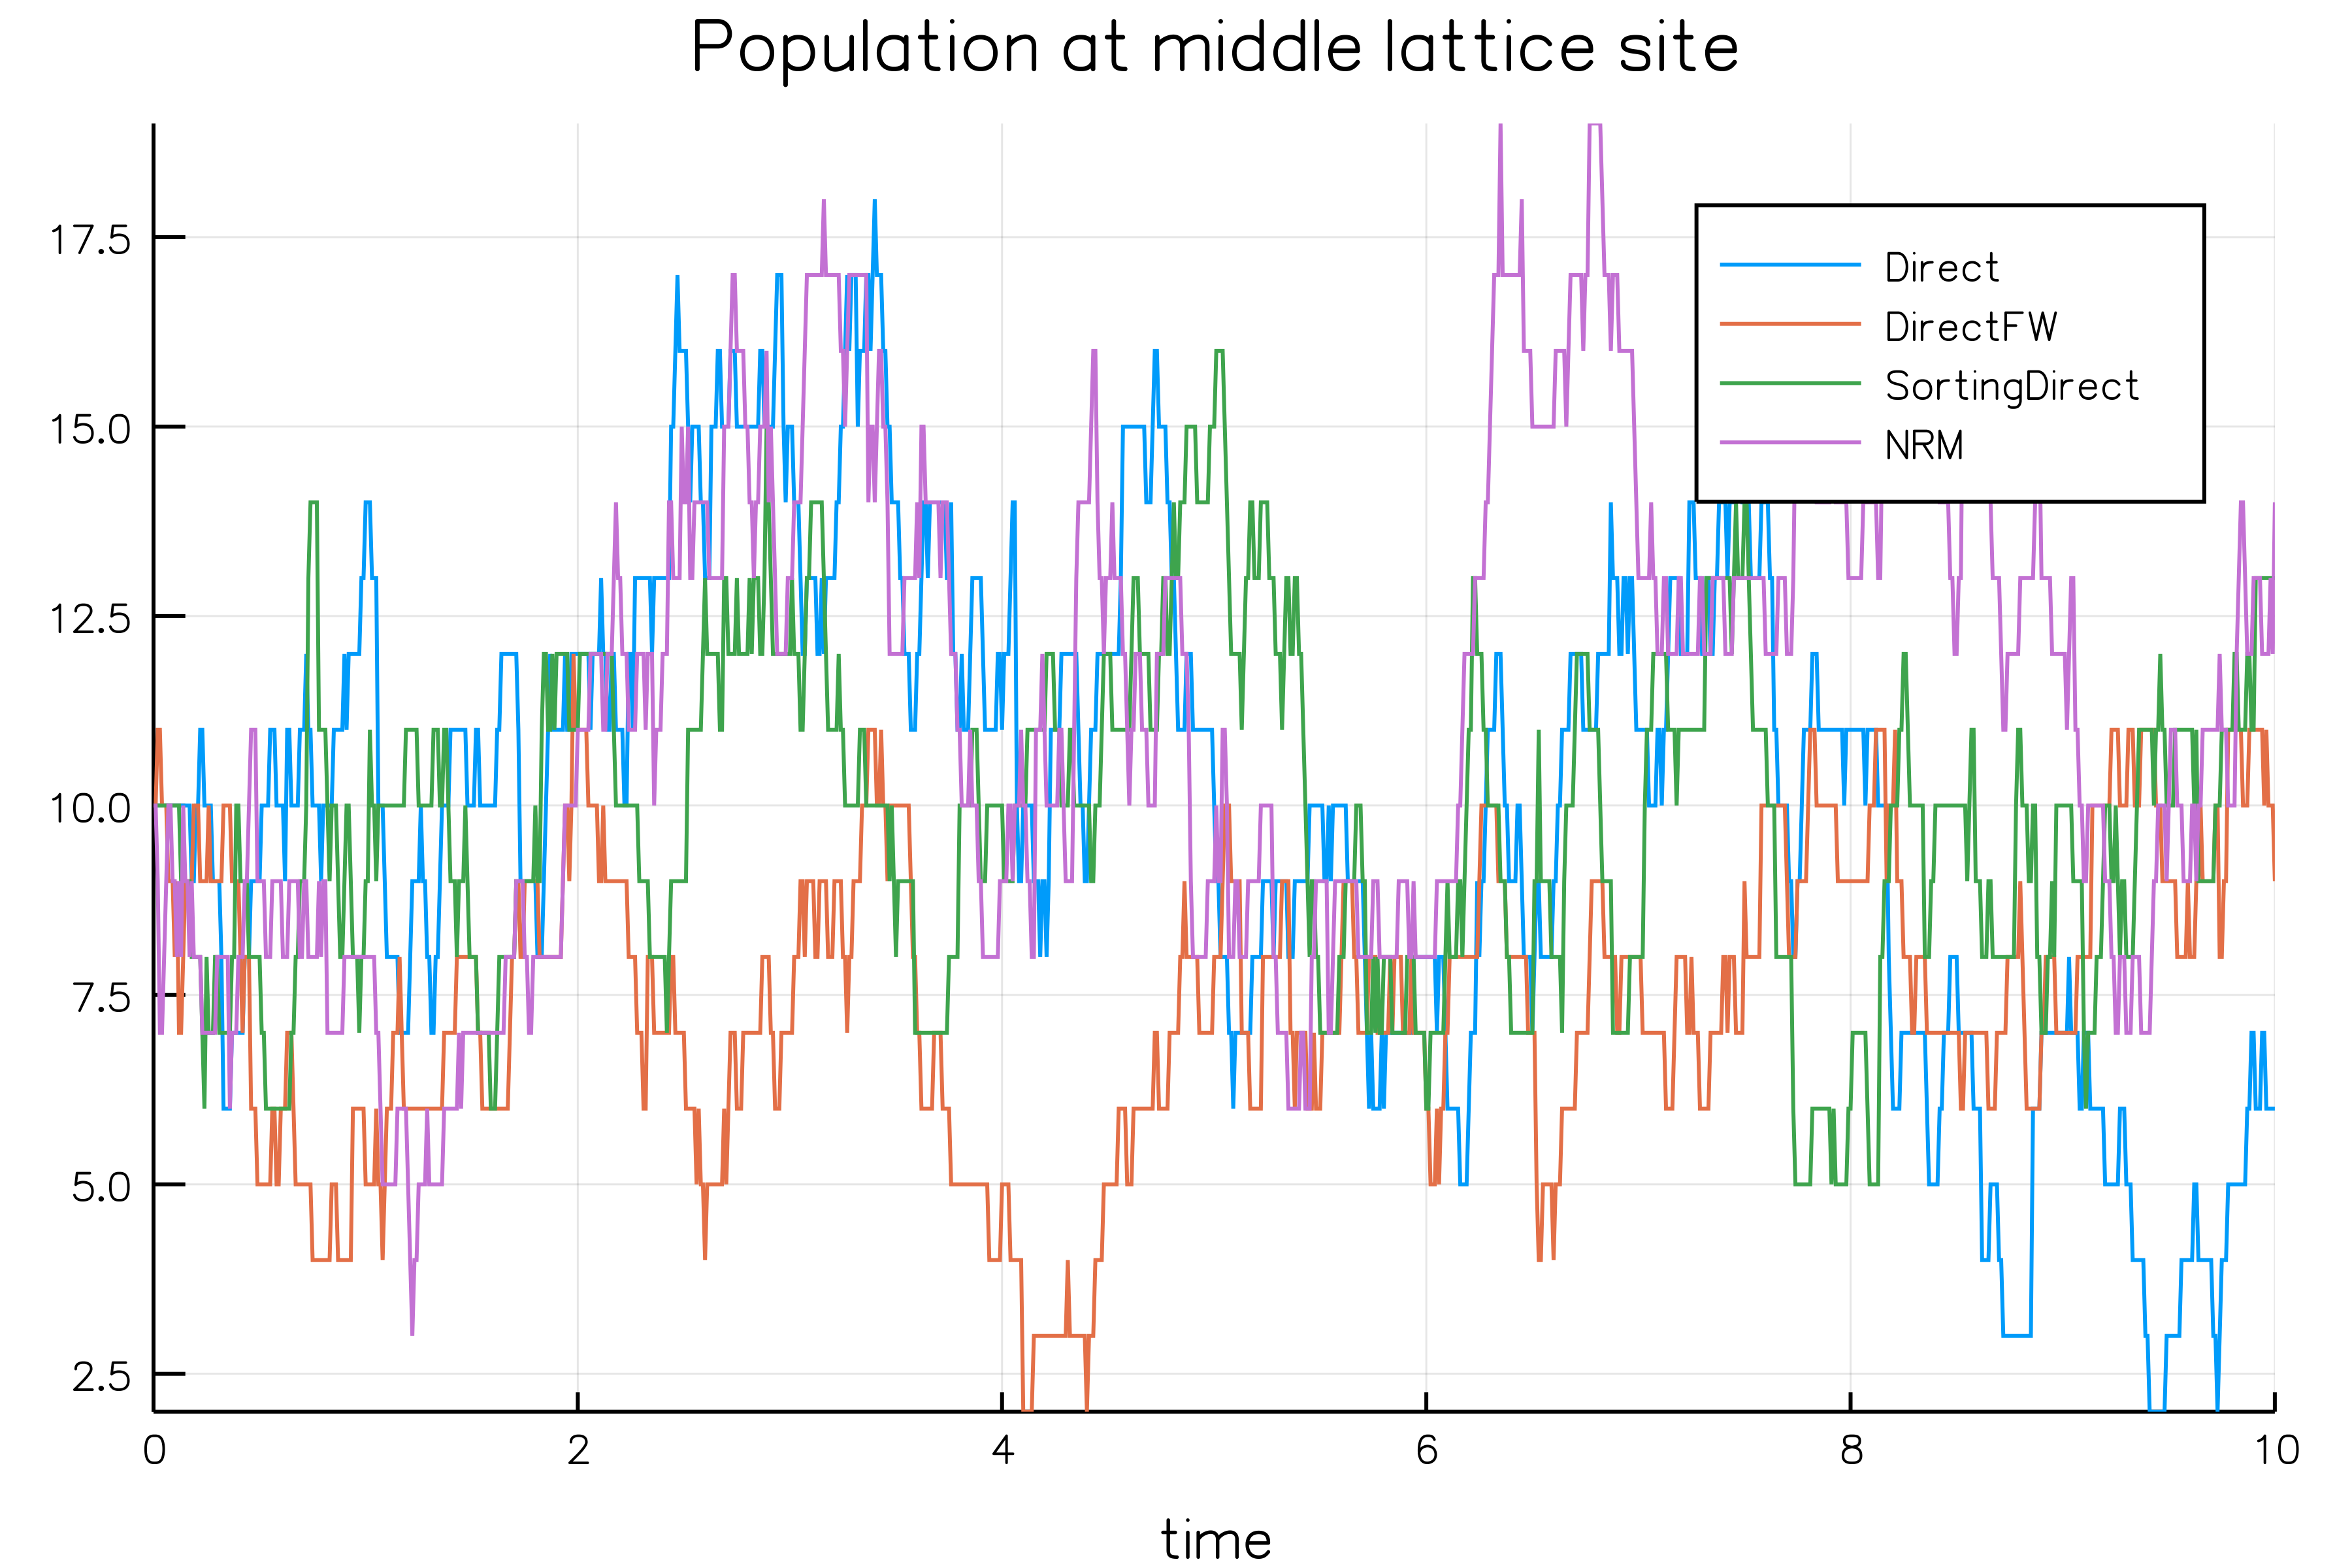

In [3]:
methods = (Direct(),DirectFW(),SortingDirect(),NRM())
legs    = [typeof(method) for method in methods]
shortlabels = [string(leg)[12:end] for leg in legs]
fmt     = :png
prob    = prob = DiscreteProblem(u0, (0.0, tf), rnpar)
ploth   = plot(reuse=false)
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    plot!(ploth,sol.t,sol[Int(N//2),:],label=shortlabels[i], format=fmt)
end
plot(ploth, title="Population at middle lattice site", xlabel="time",format=fmt)

# Benchmarking performance of the methods

In [4]:
function run_benchmark!(t, jump_prob, stepper)
    sol = solve(jump_prob, stepper)
    @inbounds for i in 1:length(t)
        t[i] = @elapsed (sol = solve(jump_prob, stepper))
    end
end

run_benchmark! (generic function with 1 method)

In [5]:
nsims = 50
benchmarks = Vector{Vector{Float64}}()
gc()
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    stepper = SSAStepper()
    t = Vector{Float64}(nsims)
    run_benchmark!(t, jump_prob, stepper)
    push!(benchmarks, t)
end

In [8]:
medtimes = Vector{Float64}(length(methods))
stdtimes = Vector{Float64}(length(methods))
avgtimes = Vector{Float64}(length(methods))
for i in 1:length(methods)
    medtimes[i] = median(benchmarks[i])
    avgtimes[i] = mean(benchmarks[i])
    stdtimes[i] = std(benchmarks[i])
end
using DataFrames

df = DataFrame(names=shortlabels,medtimes=medtimes,relmedtimes=(medtimes/medtimes[1]),avgtimes=avgtimes, std=stdtimes, cv=stdtimes./avgtimes)

,names,medtimes,relmedtimes,avgtimes,std,cv
1,Direct,0.157339,1.0,0.15735,0.00552879,0.0351369
2,DirectFW,0.152384,0.968508,0.153132,0.004357,0.0284525
3,SortingDirect,0.020618,0.131042,0.0206939,0.000931787,0.0450272
4,NRM,0.013306,0.0845691,0.0138843,0.00109407,0.0787993
